In [3]:
import xarray as xr
import pyorc
from matplotlib.colors import Normalize

In [4]:
ds = xr.open_dataset("Outputs/BR.nc")

Scanning video: 100%|██████████| 125/125 [00:09<00:00, 12.51it/s]


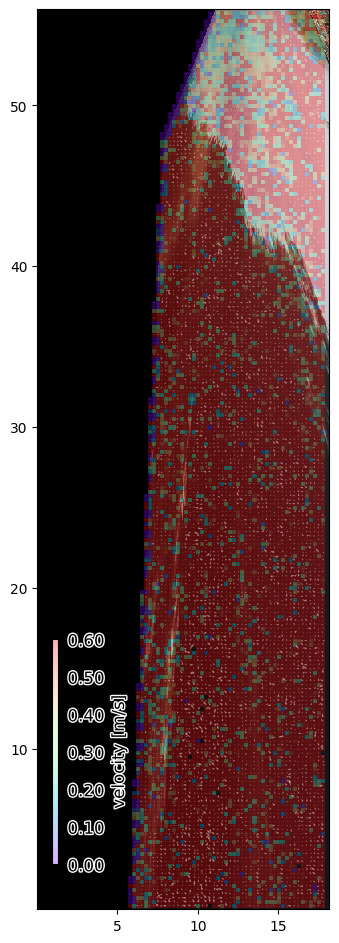

In [5]:
# first re-open the original video, extract one RGB frame and plot that
video_file = r"../Videos/bridge_main_1.mp4"

video = pyorc.Video(video_file, start_frame=0, end_frame=125)
# borrow the camera config from the velocimetry results
video.camera_config = ds.velocimetry.camera_config

da_rgb = video.get_frames(method="rgb")
# project the rgb frame
da_rgb_proj = da_rgb.frames.project()
# plot the first frame (we only have one) without any arguments, default is to use "local" mode
p = da_rgb_proj[0].frames.plot()

# now plot the results on top, we use the mean, because we cannot plot more than 2 dimensions. 
# Default plotting method is "quiver", but "scatter" or "pcolormesh" is also possible.
# We add a nice colorbar to understand the magnitudes.
# We give the existing axis handle of the mappable returned from .frames.plot to plot on, and use 
# some transparency.
ds_mean = ds.mean(dim="time", keep_attrs=True)

# first a pcolormesh
ds_mean.velocimetry.plot.pcolormesh(
    ax=p.axes,
    alpha=0.3,
    cmap="rainbow",
    add_colorbar=True,
    vmax=0.6
)

ds_mean.velocimetry.plot(
    ax=p.axes,
    color="w",
    alpha=0.5,
)


f:\OnGoingProj\CWPRS\pyORC\pyorc_env\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
f:\OnGoingProj\CWPRS\pyORC\pyorc_env\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


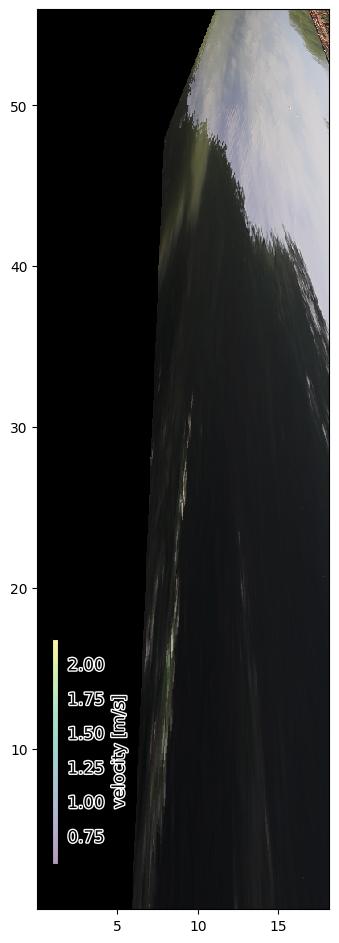

In [6]:
import copy
ds_mask = copy.deepcopy(ds)
mask_corr = ds_mask.velocimetry.mask.corr(inplace=True)
mask_minmax = ds_mask.velocimetry.mask.minmax(inplace=True)
mask_rolling = ds_mask.velocimetry.mask.rolling(inplace=True)
mask_outliers = ds_mask.velocimetry.mask.outliers(inplace=True)
mask_var = ds_mask.velocimetry.mask.variance(inplace=True)
mask_angle = ds_mask.velocimetry.mask.angle(inplace=True)
mask_count = ds_mask.velocimetry.mask.count(inplace=True)


# apply the plot again, let's leave out the scalar values, and make the quivers a bit nicer than before.
ds_mean_mask = ds_mask.mean(dim="time", keep_attrs=True)


# again the rgb frame first
p = da_rgb_proj[0].frames.plot()

#...and then masked velocimetry
ds_mean_mask.velocimetry.plot(
    ax=p.axes,
    alpha=0.4,
    norm=Normalize(vmax=0.6, clip=False),
    add_colorbar=True
)


f:\OnGoingProj\CWPRS\pyORC\pyorc_env\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
f:\OnGoingProj\CWPRS\pyORC\pyorc_env\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


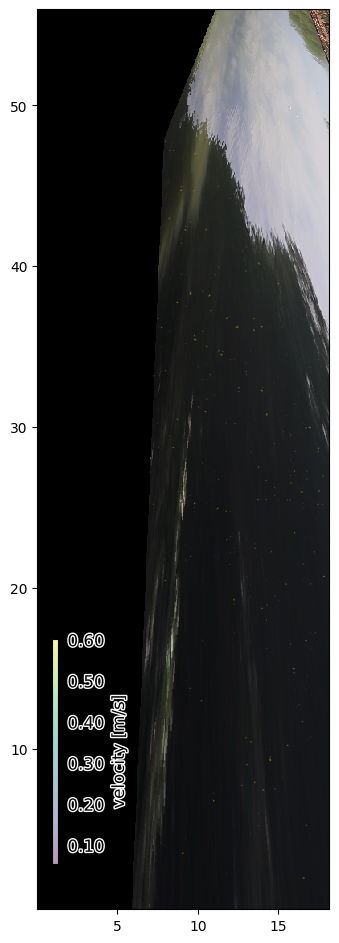

In [7]:
# apply all methods in time domain with relaxed angle masking
import numpy as np
ds_mask2 = copy.deepcopy(ds)
ds_mask2.velocimetry.mask.corr(inplace=True)
ds_mask2.velocimetry.mask.minmax(inplace=True)
ds_mask2.velocimetry.mask.rolling(inplace=True)
ds_mask2.velocimetry.mask.outliers(inplace=True)
ds_mask2.velocimetry.mask.variance(inplace=True)
ds_mask2.velocimetry.mask.angle(angle_tolerance=0.5*np.pi)
ds_mask2.velocimetry.mask.count(inplace=True)
ds_mask2.velocimetry.mask.window_mean(wdw=2, inplace=True, tolerance=0.5, reduce_time=True)

# Now first average in time before applying any filter that only works in space.
ds_mean_mask2 = ds_mask2.mean(dim="time", keep_attrs=True)

# apply the plot again
# again the rgb frame first
p = da_rgb_proj[0].frames.plot()

#...and then filtered velocimetry
ds_mean_mask2.velocimetry.plot(
    ax=p.axes,
    alpha=0.4,
    norm=Normalize(vmax=0.6, clip=False),
    add_colorbar=True
)


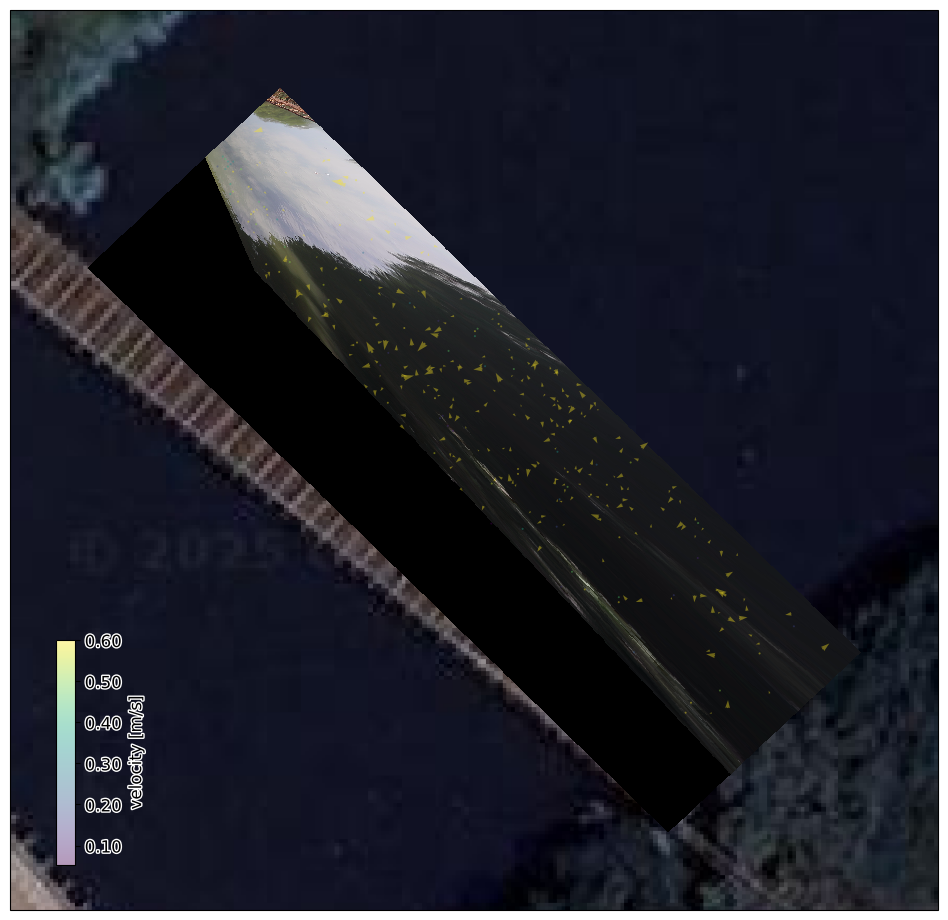

In [8]:
# again the rgb frame first. But now we use the "geographical" mode to plot on a map
p = da_rgb_proj[0].frames.plot(mode="geographical")

#...and then masked velocimetry again, but also geographical
ds_mean_mask2.velocimetry.plot(
    ax=p.axes,
    mode="geographical",
    alpha=0.4,
    norm=Normalize(vmax=0.6, clip=False),
    add_colorbar=True
)

# for fun, let's also add a satellite background from cartopy
import cartopy.io.img_tiles as cimgt
import cartopy.crs as ccrs
tiles = cimgt.GoogleTiles(style="satellite")
p.axes.add_image(tiles, 19)
# zoom out a little bit so that we can actually see a bit
p.axes.set_extent([
    da_rgb_proj.lon.min() - 0.00005,
    da_rgb_proj.lon.max() + 0.00005,
    da_rgb_proj.lat.min() - 0.00005,
    da_rgb_proj.lat.max() + 0.00005],
    crs=ccrs.PlateCarree()
)


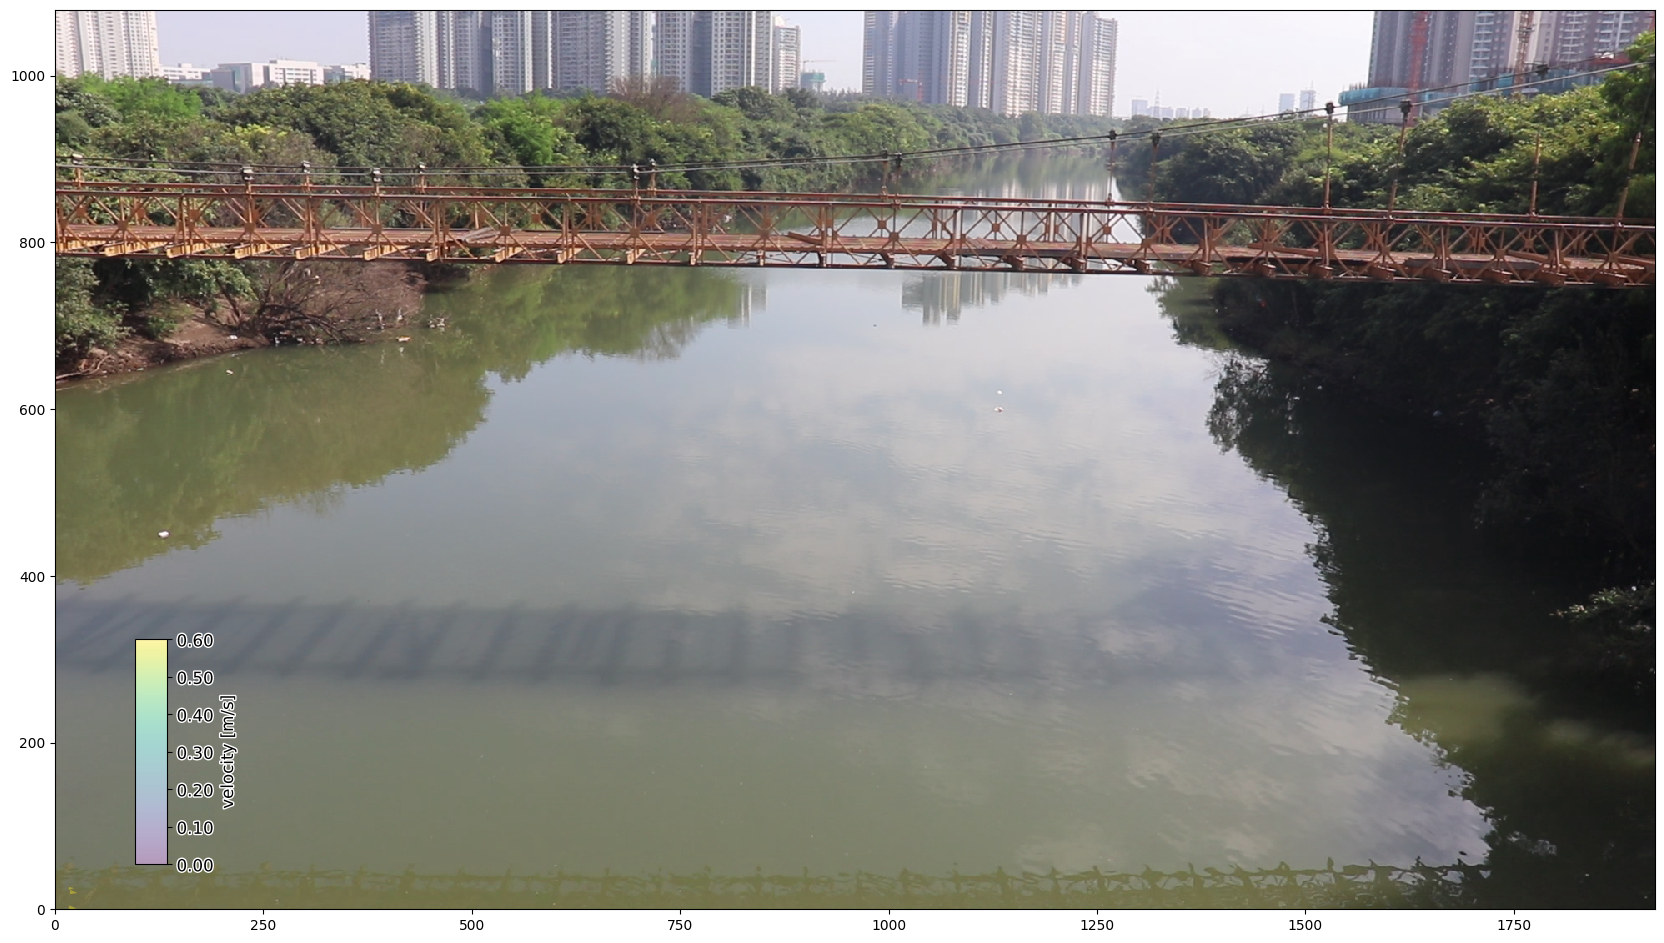

In [9]:
# again the rgb frame first, but now the unprojected one. Now we use the "camera" mode to plot the camera perspective
p = da_rgb[0].frames.plot(mode="camera")

#...and then masked velocimetry again, but also camera. This gives us an augmented reality view. The quiver scale 
# needs to be adapted to fit in the screen properly
ds_mean_mask.velocimetry.plot(
    ax=p.axes,
    #mode="camera",
    alpha=0.4,
    norm=Normalize(vmin=0., vmax=0.6, clip=False),
    add_colorbar=True
)


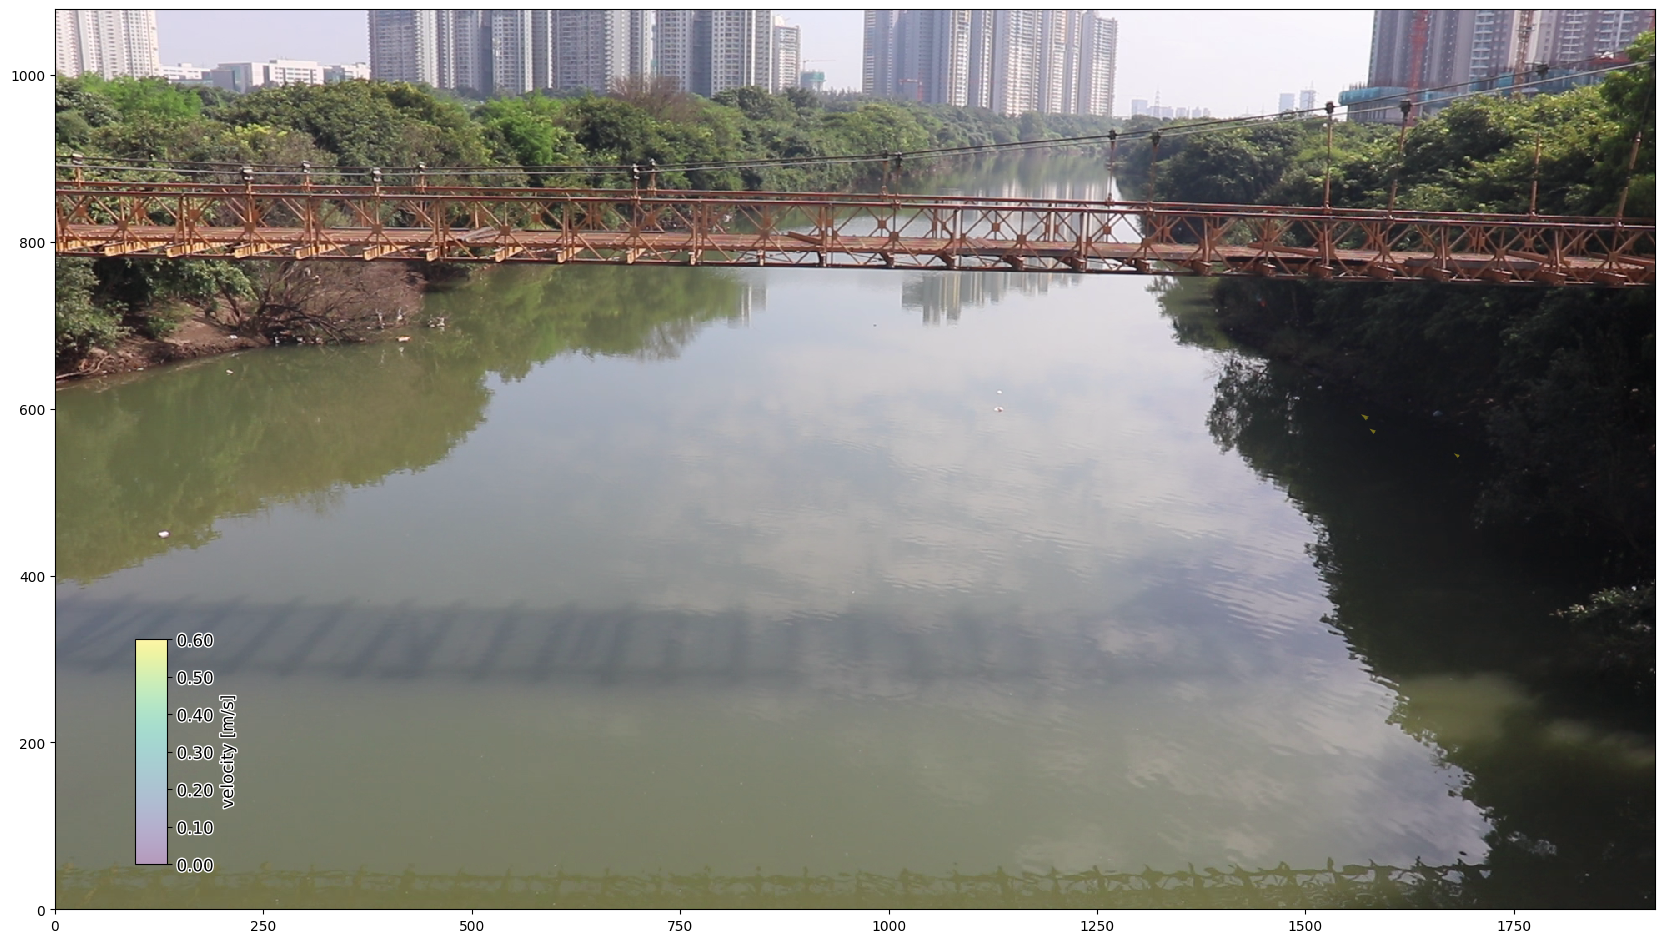

In [20]:
# Set the water level on the Dataset's attributes as a STRING 
ds_mean_mask.attrs['h_a'] = '0.75' 

# again the rgb frame first, but now the unprojected one. Now we use the "camera" mode to plot the camera perspective
p = da_rgb[0].frames.plot(mode="camera")

#...and then masked velocimetry again, but also camera. This gives us an augmented reality view. The quiver scale 
# needs to be adapted to fit in the screen properly
ds_mean_mask.velocimetry.plot(
    ax=p.axes,
    mode="camera",
    alpha=0.4,
    norm=Normalize(vmin=0.0, vmax=0.6),
    add_colorbar=True
)